In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../functions/')

from adjust_lon_xr_dataset import adjust_lon_xr_dataset
from convert_era5_to_Wm2 import convert_era5_to_Wm2

from map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs


from scipy.interpolate import griddata
import gsw

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def convert_longitude(longitude):
    if longitude < 0:
        return longitude + 360
    else:
        return longitude

#### Read and save storm tracks

In [ ]:
# get all cyclones

for yr in tqdm(range(1981, 2021)):
    
    stm = pd.read_csv('/Volumes/LaCie/Work/data/lodise2022_cyclones/SO_EC_tracks/SO_EC_tracks_' + str(yr) + '.csv')
    
    if yr == 1981:
        
        storms = stm
        
    else:

        stm['Storm ID'] = stm['Storm ID'] + storms['Storm ID'].max()
        
        storms = pd.concat([storms, stm])

ds_cyclones = storms.to_xarray()

ds_cyclones = ds_cyclones.assign_coords(TIME = ds_cyclones['Time'].astype(np.datetime64))
ds_cyclones = ds_cyclones.swap_dims({'index': 'TIME'})

ds_cyclones = ds_cyclones.rename({'Longitude': 'LONGITUDE',
                                  'Latitude': 'LATITUDE',
                                  'Storm ID': 'STORM_ID',
                                  'Minimum Pressure (hPa)': 'PRESSURE_MIN'})

ds_cyclones = ds_cyclones.drop(labels={'index', 'Time'})

ds_cyclones.attrs['dataset'] = 'Southern Ocean Extratropical Cyclone Tracks'
ds_cyclones.attrs['data source'] = 'https://github.com/jlodise/JGR2022_ExtratropicalCycloneTracker'
ds_cyclones.attrs['method'] = 'Lodise et al. 2022 - Global Climatology of Extratropical Cyclones From a New Tracking Approach and Associated Wave Heights from Satellite Radar Altimeter'
ds_cyclones.attrs['original data'] = 'ERA5 (https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)'

  0%|          | 0/40 [00:00<?, ?it/s]

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_22341/2243589212.py:19: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_cyclones = ds_cyclones.assign_coords(TIME = ds_cyclones['Time'].astype(np.datetime64))


In [4]:
# read in the cyclone dataset

ds_summer = ds_cyclones.sel(TIME=ds_cyclones.TIME.dt.season=="DJF")
ds_summer = ds_summer.isel(TIME=ds_summer.LATITUDE.data < -40)

In [5]:
# read in the land sea mask from era5

lsm = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/reanalysis/era5/land_sea_mask.nc')

lsm = adjust_lon_xr_dataset(lsm).sel(latitude=slice(-40, -90))

lsm_lats = lsm.latitude.values
lsm_lons = lsm.longitude.values

In [6]:
# create lon/lat array where there is land (>0)

land_lons = []
land_lats = []

for i, lon in tqdm(enumerate(lsm_lons)):

    for j, lat in enumerate(lsm_lats):

        if lsm.sel(longitude=lon, latitude=lat).lsm > 0:

            land_lons += lon,
            land_lats += lat, 

land_lons = np.array(land_lons)
land_lats = np.array(land_lats)

0it [00:00, ?it/s]

In [ ]:
# remove bad lon and lats around islands - we don't want to lose too many cyclones

# south of aus & nz
idx = ((land_lons > 135) & (land_lons < 180) & (land_lats > -60) & (land_lats < -48))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# atlantic, indian
idx = ((land_lons > -62) & (land_lons < 135) & (land_lats > -63))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# west of nz
idx = ((land_lons > -180) & (land_lons < -160) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# ross sea
idx = ((land_lons > 155) & (land_lats > -68) & (land_lats < -50))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

# abs
idx = ((land_lons > -135) & (land_lons < -76) & (land_lats > -70))

land_lats = land_lats[~idx]
land_lons = land_lons[~idx]

In [ ]:
# Precompute radians for land coordinates
land_lats_rad = np.radians(land_lats)
land_lons_rad = np.radians(land_lons)

# Precompute radians for cyclone coordinates
cyc_lats = ds_summer.LATITUDE.values
cyc_lons = ds_summer.LONGITUDE.values

cyc_lats_rad = np.radians(cyc_lats)
cyc_lons_rad = np.radians(cyc_lons)

In [3]:
def haversine_rad(lat1, lon1, lat2, lon2):
    R1 = earth_radius(lat1)  # insert latitude in radians
    R2 = earth_radius(lat2)  # insert latitude in radians
    R = (R1 + R2) / 2  # Average radius for the two latitudes
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [ ]:
# Initialize the result array
min_dist_to_land = np.ndarray([ds_summer.TIME.size])

# Vectorized distance calculation
for i in tqdm(range(ds_summer.TIME.size)):

    cyc_lat = cyc_lats_rad[i]
    cyc_lon = cyc_lons_rad[i]    
    
    # Calculate distances to all land points at once
    distances = haversine_rad(land_lats_rad, land_lons_rad, cyc_lat, cyc_lon)
    min_dist_to_land[i] = distances.min()

In [ ]:
ds_summer['min_dist_to_land'] = (('TIME'), min_dist_to_land)

In [ ]:
ds_summer.to_netcdf('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_with_min_dist_to_land.nc')

#### Cyclone analysis

In [2]:
# read in storm center data with min dist to land

ds_summer = xr.open_dataset('/Volumes/LaCie/Work/data/lodise2022_cyclones/ec_centers_1981_2020_with_min_dist_to_land.nc')

In [3]:
# pick out all the cyclones that are within 500 km of land

ds_summer_ocean = ds_summer.isel(TIME=ds_summer.min_dist_to_land>500)

In [4]:
# remove cyclone before december 1981

ds_summer_ocean = ds_summer_ocean.isel(TIME=ds_summer_ocean.TIME > np.datetime64('1981-12-01T00:00:00'))

In [5]:
# storm number count before land removal of storms
print('all storms:', np.unique(ds_summer.STORM_ID).size)

# storm number count where ocean only storms
print('ocean storms:', np.unique(ds_summer_ocean.STORM_ID).size)

all storms: 14895
ocean storms: 13774


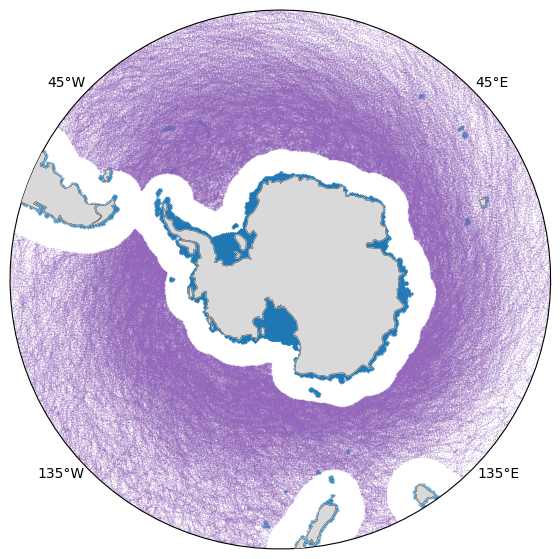

In [ ]:
# plot storm tracks

fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

ax.scatter(land_lons, land_lats, s=0.1, c='tab:blue', transform=ccrs.PlateCarree())

ax.scatter(ds_summer_ocean.LONGITUDE, ds_summer_ocean.LATITUDE, s=1, alpha=0.2, lw=0, c='tab:purple', transform=ccrs.PlateCarree())

In [6]:
def read_era5_dataset(name, year):
    print(f'reading in era5 dataset for {name} {year}')
    data_directory_in = f'/Volumes/LaCie/Work/data/era5/DJF_1981_2023_hourly_means/DJF_1981_2023_{name}/*.nc'
    file_list = sorted(glob(data_directory_in))
    
    year_str = str(year)
    next_year_str = str(year + 1)
    months = [f'{year_str}12.nc', f'{next_year_str}01.nc', f'{next_year_str}02.nc']
    
    # choose only the files that are dec, jan or feb
    filtered_files = [file for file in file_list if any(file.endswith(month) for month in months)]
    
    ds = xr.open_mfdataset(filtered_files)
    ds = ds.sel(latitude=slice(-30, -90)).load()

    ds_adjusted = adjust_lon_xr_dataset(ds)

    return ds, ds_adjusted

In [7]:
def select_data_by_year(ds, year):
    """
    Selects a portion of the data based on the given year.

    Parameters:
    ds (xarray.Dataset): The dataset to select data from.
    year (int): The year to select data for.

    Returns:
    xarray.Dataset: The dataset containing data for the specified year.
    """
    print(f'Selecting storm data for year {year}')
    return ds.isel(TIME=((ds.TIME > np.datetime64(f'{year}-12-01')) & (ds.TIME < np.datetime64(f'{year+1}-03-01'))))

# Example usage:
# year = 1981
# ds_storms_1981 = select_data_by_year(ds_summer_ocean, year)
# print(ds_storms_1981)

In [8]:
def convert_longitude(longitude):
    if longitude < 0:
        return longitude + 360
    else:
        return longitude

In [ ]:
len_storms = [ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==storm).dim['TIME'] for storm in np.unique(ds_summer_ocean.STORM_ID)]

(array([4.930e+02, 6.980e+02, 7.970e+02, 7.760e+02, 1.782e+03, 1.576e+03,
        1.352e+03, 1.149e+03, 9.600e+02, 8.170e+02, 7.020e+02, 5.080e+02,
        4.200e+02, 3.560e+02, 2.870e+02, 2.260e+02, 1.890e+02, 1.540e+02,
        1.240e+02, 9.100e+01, 6.800e+01, 6.700e+01, 4.800e+01, 2.500e+01,
        2.600e+01, 2.100e+01, 1.100e+01, 7.000e+00, 1.300e+01, 9.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00]),
 array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
         66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
        132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
        198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.]),
 <BarContainer object of 43 artists>)

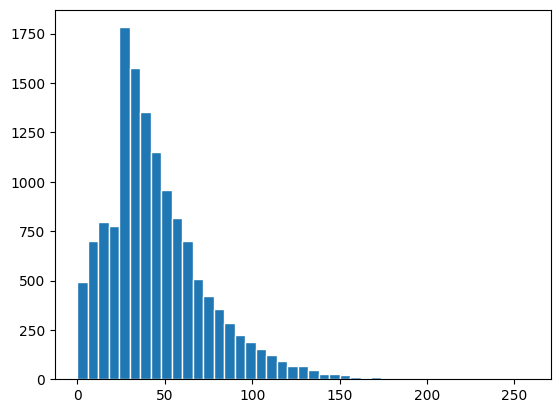

In [ ]:
plt.hist(np.array(len_storms), bins=np.arange(0, 264, 6), edgecolor='w')

In [ ]:
# filter out storms that are less than 24 hours long

storm_id_24hours = np.unique(ds_summer_ocean.STORM_ID)[np.array(len_storms)<24]

filter_array = []

for unique_storm_id in tqdm(np.unique(ds_summer_ocean.STORM_ID)):
    
    if unique_storm_id in storm_id_24hours:
        filter_array.append(np.zeros(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

    else:
        filter_array.append(np.ones(ds_summer_ocean.isel(TIME=ds_summer_ocean.STORM_ID==unique_storm_id).TIME.size))

filter_array = np.concatenate(filter_array)

ds_summer_ocean_filtered = ds_summer_ocean.isel(TIME=filter_array==1)        

100%|██████████| 13774/13774 [00:21<00:00, 643.59it/s]


In [ ]:
# create new storm id for the filtered dataset

new_storm_id = []
counter = 0

for unique_storm_id in tqdm(np.unique(ds_summer_ocean_filtered.STORM_ID)):
     
    counter += 1

    new_storm_id.append(np.zeros(ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==unique_storm_id).TIME.size) + counter)

new_storm_id = np.concatenate(new_storm_id).astype(int)

ds_summer_ocean_filtered['STORM_ID'] = (('TIME'), new_storm_id)

100%|██████████| 11010/11010 [00:16<00:00, 678.75it/s]


In [33]:
len_storms = [ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==storm).dims['TIME'] for storm in np.unique(ds_summer_ocean_filtered.STORM_ID)]

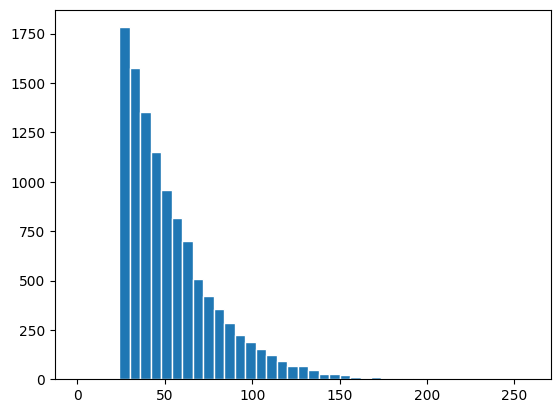

In [39]:
fig = plt.hist(np.array(len_storms), bins=np.arange(0, 264, 6), edgecolor='w')

In [43]:
def process_storm_data(var, ds, ds_adjusted, storm_ds, storm_id):
    print(f'Processing data for storm {storm_id}')

    new_x = np.arange(-1000, 1050, 50)
    new_y = np.arange(-1000, 1050, 50)

    ds_storm = storm_ds.isel(TIME=storm_ds.STORM_ID == storm_id)

    which_lon_grid = np.ndarray([ds_storm.TIME.size])
    lons = np.ndarray([ds_storm.TIME.size, 241])
    lats = np.ndarray([ds_storm.TIME.size, 81])

    # ds_final = xr.Dataset()

    for time_idx in tqdm(range(ds_storm.TIME.size)):
        cyclone = ds_storm.isel(TIME=time_idx)  # choose one cyclone position at a time

        if (cyclone.LONGITUDE > 150) or (cyclone.LONGITUDE < -150):
            ref_lon = convert_longitude(cyclone.LONGITUDE.values)
            ref_lat = cyclone.LATITUDE.values

            ds_ = ds.sel(time=cyclone.TIME.values,
                         latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                         longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30))
            
            which_lon_grid[time_idx] = 1  # give a value that represents a grid of 0 to 360

        else:
            ref_lon = cyclone.LONGITUDE.values
            ref_lat = cyclone.LATITUDE.values

            ds_ = ds_adjusted.sel(time=cyclone.TIME.values,
                                  latitude=slice(np.round(ref_lat) + 10, np.round(ref_lat) - 10),
                                  longitude=slice(np.round(ref_lon) - 30, np.round(ref_lon) + 30))
            
            which_lon_grid[time_idx] = 0  # give a value that represents a grid of -180 to 180

        lats = ds_.latitude.values
        lons = ds_.longitude.values

        # longitude to distance interpolation
        dist_from_lon = np.zeros([81, 241])

        for j, lt in enumerate(lats):
            for i, ln in enumerate(lons):
                dist_from_lon[j, i] = gsw.distance([ln, ref_lon], [lt, lt])[0] / 1000

            dist_from_lon[j][lons < ref_lon] = -dist_from_lon[j][lons < ref_lon]

        # latitude to distance interpolation
        dist_from_lat = np.zeros(lats.size)

        for j, lt in enumerate(lats):
            dist_from_lat[j] = gsw.distance([lons[0], lons[0]], [lt, ref_lat])[0] / 1000

        dist_from_lat[lats < ref_lat] = -dist_from_lat[lats < ref_lat]

        for v in var:
            new_data = np.zeros([81, new_x.size])
            final_data = np.zeros([new_x.size, new_y.size])

            data = ds_[v]

            for j in range(lats.size):
                new_data[j, :] = griddata(dist_from_lon[j], data[j], new_x)

            for i in range(new_x.size):
                final_data[:, i] = griddata(dist_from_lat, new_data[:, i], new_y)

            ds_var = xr.Dataset(
                {v: (['time', 'x', 'y'], final_data[np.newaxis, :, :]),
                 'pressure': (['time'], [cyclone.PRESSURE_MIN.data]),
                 'storm_id': (['time'], [cyclone.STORM_ID.data]),
                 },
                coords={
                    'x': ('x', new_x),
                    'y': ('y', new_y),
                    'time': ('time', [pd.to_datetime(cyclone.TIME.data)]),
                    'lon': ('time', [ref_lon]),
                    'lat': ('time', [ref_lat]),                
                }
            )
    
            if 'ds_final' in locals() and isinstance(ds_final, xr.Dataset):
                ds_final = xr.concat([ds_final, ds_var], dim='time')

            else:
                ds_final = ds_var 

    ## Example padding logic (adjust as needed)
    max_time_length = 300  # Define a maximum length for the time dimension
    time_length = ds_final.dims['time']
    #
    if time_length < max_time_length:
        pad_width = max_time_length - time_length
        pad_values = {dim: (0, pad_width) for dim in ds_final.dims if dim == 'time'}
        ds_final = ds_final.pad(pad_values, constant_values=0)           
    
    return ds_final

# Example usage:
#var = ['t2m']
#ds_final = process_storm_data(var, era5_ds, era5_ds_adjusted, ds_storms_1981, ds_storms_1981.STORM_ID[0])

In [36]:
from joblib import Parallel, delayed

def process_storms(names, vars, storms_ds, year, storm_id=None):
    """
    Function to process all storms for a given year or a specific storm.
    Args:
    name: str
        Name of the dataset to be used. Options: '2m_temperature', 'winds', 'sea_ice_cover'
    var: str
        Variable to be processed. Options: 't2m', 'u10', 'v10', 'siconc'
    storms_ds: xarray.Dataset
        Dataset containing the storms data
    year: int
        Year to be processed
    storm_id: int
        Storm ID to be processed. If None, all storms for the year will be processed

    Returns:
    ds_all: xarray.Dataset
        Dataset containing the processed data
    """
    import numpy as np
    import xarray as xr

    def read_and_merge_datasets(names, year):
        datasets = [read_era5_dataset(name, year) for name in names]
        era5_ds_all = xr.merge([ds[0] for ds in datasets])
        era5_ds_adjusted_all = xr.merge([ds[1] for ds in datasets])
        return era5_ds_all, era5_ds_adjusted_all

    era5_ds_all, era5_ds_adjusted_all = read_and_merge_datasets(names, year)
    ds_storms_year = select_data_by_year(storms_ds, year)

    def process_single_storm(storm):
        return process_storm_data(vars, era5_ds_all, era5_ds_adjusted_all, ds_storms_year, storm)

    if storm_id is None:
        print(f'No storms provided, using all storms for the year {year}. Total number of storms: {len(np.unique(ds_storms_year.STORM_ID.values))}')
        storm_ids = np.unique(ds_storms_year.STORM_ID.values)

        # Use parallel processing to handle multiple storms simultaneously
        results = Parallel(n_jobs=-1)(delayed(process_single_storm)(storm) for storm in storm_ids)
        ds_all = xr.concat(results, dim='time', join='outer')

    else:
        storm = storm_id
        ds_all = process_single_storm(storm)

    return ds_all

In [56]:
ds_test = ds_summer_ocean_filtered.isel(TIME=ds_summer_ocean_filtered.STORM_ID==8)

In [59]:
ds_test.TIME

<xarray.DataArray 'TIME' (TIME: 28)>
array(['1981-12-01T17:00:00.000000000', '1981-12-01T18:00:00.000000000',
       '1981-12-01T19:00:00.000000000', '1981-12-01T20:00:00.000000000',
       '1981-12-01T21:00:00.000000000', '1981-12-01T22:00:00.000000000',
       '1981-12-01T23:00:00.000000000', '1981-12-02T00:00:00.000000000',
       '1981-12-02T01:00:00.000000000', '1981-12-02T02:00:00.000000000',
       '1981-12-02T03:00:00.000000000', '1981-12-02T04:00:00.000000000',
       '1981-12-02T05:00:00.000000000', '1981-12-02T06:00:00.000000000',
       '1981-12-02T07:00:00.000000000', '1981-12-02T08:00:00.000000000',
       '1981-12-02T09:00:00.000000000', '1981-12-02T10:00:00.000000000',
       '1981-12-02T11:00:00.000000000', '1981-12-02T12:00:00.000000000',
       '1981-12-02T13:00:00.000000000', '1981-12-02T14:00:00.000000000',
       '1981-12-02T15:00:00.000000000', '1981-12-02T16:00:00.000000000',
       '1981-12-02T17:00:00.000000000', '1981-12-02T18:00:00.000000000',
       '1981-12-02T19:00:00.000000000', '1981-12-02T20:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * TIME     (TIME) datetime64[ns] 1981-12-01T17:00:00 ... 1981-12-02T20:00:00

In [60]:
ds_test = ds_test.assign_coords(TIME = ds_test.TIME.astype(np.datetime64))

In [ ]:
ds_all = process_storms(names=['2m_temperature'], vars=['t2m'], storms_ds=ds_test, year=1981, storm_id=None)

reading in era5 dataset for 2m_temperature 1981
Selecting storm data for year 1981
No storms provided, using all storms for the year 1981. Total number of storms: 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2

 25%|██▌       | 7/28 [00:07<00:21,  1.04s/it]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 241 but corresponding boolean dimension is 240

: 

In [31]:
pad_values = {'time': (0, 276)}

ds_all.pad(pad_values, constant_values=0).t2m.shape

(300, 41, 41)

In [ ]:
era5_ds['ws'] = (('time', 'latitude', 'longitude'), np.sqrt(era5_ds.u10.data**2 + era5_ds.v10.data**2))

: 

In [62]:
# Define the threshold distance (radius) in km
threshold_distance = 800

# Get the dimensions of the array
rows = len(new_y)
cols = len(new_x)

# Calculate the center point
center_x = rows // 2
center_y = cols // 2

# Create a new 2D array to store the result
radial_idx = np.zeros((rows, cols), dtype=int)*np.NaN

# Iterate through the 2D array
for i in range(rows):
    for j in range(cols):
        # Calculate the distance from the center point
        distance = np.sqrt((new_x[i] - new_x[center_x])**2 + (new_y[j] - new_y[center_y])**2)
        # Check if the distance is within the threshold
        if distance <= threshold_distance:
            radial_idx[i][j] = 1

MovieWriter Pillow unavailable; using Pillow instead.


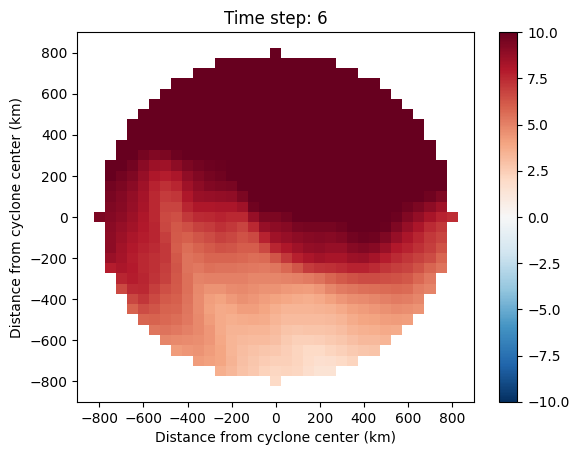

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Sample 3D array (time, lat, lon) with random data for demonstration purposes
time_steps = ds_final.time.size

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    img = ax.pcolormesh(new_x, new_y, ds_final['t2m'][frame]*radial_idx-273.15, cmap='RdBu_r', vmin=-10, vmax=10)
    ax.set_title(f'Time step: {frame}')
    ax.set_xlabel('Distance from cyclone center (km)')
    ax.set_ylabel('Distance from cyclone center (km)')
    ax.set_xlim(-900, 900); ax.set_ylim(-900, 900)
    # ax.contour(new_x, new_y, radial_idx, levels=np.arange(0,1), colors='k')
    return img,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(time_steps), blit=True) 

# Add colorbar only once
cbar = fig.colorbar(ax.pcolormesh(new_x, new_y, ds_final['t2m'][0]*radial_idx-273.15, cmap='RdBu_r', vmin=-10, vmax=10), ax=ax)

# Save the animation as a video file
ani.save('t2m_storm.gif', writer='Pillow') # can also save with writer imagemagick

# Display the animation
plt.show()